In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
import random

import numpy as np

import boto3
import sagemaker

import io
import json
from pathlib import Path

from site_tools import category2mask
from site_tools import compute_iou
from site_tools import get_matching_s3_keys
from site_tools import do_crf


profile = 'crayon-site'
region_name='us-east-2'
bucket = 'st-crayon-dev'
prefix = 'sagemaker/labelbox/'

endpoint_name = 'lss-all-ml-p2-xlarge'



In [2]:
session = boto3.session.Session(profile_name = profile, region_name = region_name)
sess = sagemaker.Session(session,default_bucket=bucket)
s3 = session.resource('s3', region_name=region_name)
bucket_obj = s3.Bucket(bucket)
runtime_client = session.client('runtime.sagemaker')

In [3]:
manifest_filepath = 'data/raw/imgs/tiles_1024/manifests/manifest_file_test_imgs.json'
manifest_file = bucket_obj.Object(key=manifest_filepath).get()
manifest_file = manifest_file['Body'].read().decode('ascii')
j_content = json.dumps(manifest_file)
j_content = json.loads(j_content)

manifest_list = []
for line in j_content.splitlines():
     line = json.loads(line)
     manifest_list.append(line)

source_ref = [f['source-ref'].replace(f's3://{bucket}/','') for f in manifest_list]
annontation_ref = [f['annotation-ref'].replace(f's3://{bucket}/','') for f in manifest_list]

# source_ref_samp = source_ref[:10]
# annontation_ref_sam = annontation_ref[:10]

all_img = source_ref + annontation_ref
print(f'total number of image to be copied = {len(all_img)}')

total number of image to be copied = 1188


In [4]:
for img in all_img:
    p = Path(img)

    file_nam_wo_ext = p.stem
    base_loc = img.split('/')[:-2]
    base_loc = '/'.join(base_loc)

    copy_source = {
    'Bucket': bucket,
    'Key': img
    }
    
    if '/images/' in str(p):
        destination = f'{base_loc}/testing/images/{file_nam_wo_ext}.jpg'
    elif '/annotations/' in str(p):
        destination = f'{base_loc}/testing/annotations/{file_nam_wo_ext}.png'
    
    # print(f'{copy_source=}')
    try:
        s3.meta.client.copy(copy_source, bucket, destination)
    except:
        print(f'Files not copied :-\n{copy_source=}\n{destination=}')
    # print(f'{destination=}')
print('File copying complete')
    

File copying complete


In [4]:
%%time
# endpoint_name = 'ss-labelbox-I1024-B1024-C896-E20'
random_img_list = random.sample(range(0, len(source_ref)), 2)
# random_img_list = [498, 281, 298, 252, 38, 93, 458, 532, 434, 589]
print(random_img_list)


fig, axs = plt.subplots(len(random_img_list), 4, figsize=(16, len(random_img_list)*6), constrained_layout=True)

for i, img_num in enumerate(random_img_list):
    print(f'processing image-{img_num}-iteration-{i}')
    print(source_ref[img_num])
    image_object = bucket_obj.Object(source_ref[img_num])
    mask_object = bucket_obj.Object(annontation_ref[img_num])
    
    img_byte_obj = io.BytesIO(image_object.get()['Body'].read())
    img = mpimg.imread(img_byte_obj, 'jpg')
    mask = np.array(Image.open(io.BytesIO(mask_object.get()['Body'].read())))
    
    
    img_4_pred = Image.open(img_byte_obj)

    imgByteArr = io.BytesIO()
    img_4_pred.save(imgByteArr, format='PNG')
    imgByteArr = imgByteArr.getvalue()
    # print(type(imgByteArr))

    response = runtime_client.invoke_endpoint(EndpointName = endpoint_name,
                                         ContentType = 'image/jpeg',
                                         Accept = 'image/png',
                                         Body = imgByteArr)
    
    prediction = response['Body'].read() 
    # get predicted mask
    mask_pred = np.array(Image.open(io.BytesIO(prediction)))
    # implement crf postprocessing
    mask_pred_crf = do_crf(img, mask_pred,zero_unsure=False)

    # calculate iou and miou per image
    miou, iou = compute_iou(mask, mask_pred, num_cls=8)
    miou_crf, iou_crf = compute_iou(mask, mask_pred_crf, num_cls=8)

    mask = category2mask(mask)
    mask_pred = category2mask(mask_pred)
    mask_pred_crf = category2mask(mask_pred_crf)
# Plot
    axs[i,0].imshow(img,cmap='gray')
    axs[i,0].set_title('orignal image iou')
    axs[i,1].imshow(mask,cmap='gray')
    axs[i,1].set_title('image mask')
    axs[i,2].imshow(mask_pred,cmap='gray')
    axs[i,2].set_title(f'predicted mask \nmiou={miou}\niou\n{iou}')
    axs[i,3].imshow(mask_pred_crf,cmap='gray')
    axs[i,3].set_title(f'predicted mask \nmiou={miou_crf}\niou{iou_crf}')


[289, 220]
processing image-289-iteration-0
data/raw/imgs/tiles_1024/images/20-OR-1086_-_Mapping_-_PDX_14_mapping_133-000002.jpg


ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint lss-all-ml-p2-xlarge of account 395166463292 not found.

# Display pictures from different folder in s3

In [4]:
prefix1 = 'data/raw/imgs/original/testing/anno_lss-p3-xlarge-400-deeplab'
prefix2 = 'data/raw/imgs/original/testing/anno_lss-all-ml-p2-xlarge-chip1024-crf'
suffix = 'PNG'

list_1 = get_matching_s3_keys(bucket, prefix=prefix1, suffix=suffix, profile= "crayon-site", region= "us-east-2")
list_2 = get_matching_s3_keys(bucket, prefix=prefix2, suffix=suffix, profile= "crayon-site", region= "us-east-2")



flist_1 = [f for f in list_1]
flist_2 = [f.replace(f.split('/')[-2], 'anno_lss-all-ml-p2-xlarge-chip1024-crf') for f in list_2]
flist_3 = [f.replace('testing/anno_lss-all-ml-p2-xlarge-chip1024-crf', 'images') for f in flist_2]
flist_4 = [f.replace('testing/anno_lss-all-ml-p2-xlarge-chip1024-crf', 'annotations') for f in flist_2]


fname_list_1 = [f.split('/')[-1] for f in flist_1]
fname_list_2 = [f.split('/')[-1] for f in flist_2]

common_files = [value for value in fname_list_1 if value in fname_list_2] 

flist_1 = [f for f in flist_1 if f.split('/')[-1] in common_files]
flist_2 = [f for f in flist_2 if f.split('/')[-1] in common_files]
flist_3 = [f.replace('.png', '.JPG') for f in flist_3 if f.split('/')[-1] in common_files]
flist_4 = [f for f in flist_4 if f.split('/')[-1] in common_files]
len(flist_4)



51

In [5]:
%matplotlib agg
from matplotlib.backends.backend_pdf import PdfPages

num_images = min(len(flist_1), len(flist_2))
print(len(flist_1), len(flist_2), num_images)
random_img_list = random.sample(range(0,num_images), 40)
print(random_img_list)

num_img_per_pg = 6
# classes = ["Landscape","Asphalt","Concrete","Gravel","Rooftop","None","Background","Unknown"]
pdf_file_name = f'../../../../data/{endpoint_name}-{num_img_per_pg}-{random.randint(0,10000)}.pdf'

with PdfPages(pdf_file_name) as pdf:    

    for i, img_num in enumerate(random_img_list):
        if (i % num_img_per_pg == 0):
            print('new figure')
            fig, axs = plt.subplots(num_img_per_pg, 4, figsize=(16, num_img_per_pg*6), constrained_layout=True)
        counter = i
        i = i % num_img_per_pg

        print(f'processing image-{img_num}-iteration-{i}')
        mask_object1 = bucket_obj.Object(flist_1[img_num])
        mask_object2 = bucket_obj.Object(flist_2[img_num])
        image = bucket_obj.Object(flist_3[img_num])
        mask_orig = bucket_obj.Object(flist_4[img_num])
        
        mask1 = np.array(Image.open(io.BytesIO(mask_object1.get()['Body'].read())))
        mask2 = np.array(Image.open(io.BytesIO(mask_object2.get()['Body'].read())))
        image = np.array(Image.open(io.BytesIO(image.get()['Body'].read())))
        mask_orig = np.array(Image.open(io.BytesIO(mask_orig.get()['Body'].read())))
        
        mask1 = category2mask(mask1)
        mask2 = category2mask(mask2)
        mask_orig = category2mask(mask_orig)
    # Plot
        axs[i,0].imshow(mask1,cmap='gray')
        axs[i,0].set_title('mask without crf')
        axs[i,1].imshow(mask2,cmap='gray')
        axs[i,1].set_title('mask with crf')
        axs[i,2].imshow(mask_orig,cmap='gray')
        axs[i,2].set_title(f'original mask')
        axs[i,3].imshow(image,cmap='gray')
        axs[i,3].set_title(f'original image')

        if(i % num_img_per_pg == num_img_per_pg - 1):
            pdf.savefig()
        elif(len(random_img_list) - counter == 1):
            pdf.savefig()
    plt.    ()

51 51 51
[10, 38, 8, 27, 34, 25, 5, 47, 15, 17, 33, 37, 22, 23, 29, 49, 24, 1, 36, 21, 48, 43, 6, 3, 13, 41, 12, 14, 28, 11, 45, 4, 7, 46, 50, 20, 19, 18, 32, 42]
new figure
processing image-10-iteration-0
processing image-38-iteration-1
processing image-8-iteration-2
processing image-27-iteration-3
processing image-34-iteration-4
processing image-25-iteration-5
new figure
processing image-5-iteration-0
processing image-47-iteration-1
processing image-15-iteration-2
processing image-17-iteration-3
processing image-33-iteration-4
processing image-37-iteration-5
new figure
processing image-22-iteration-0
processing image-23-iteration-1
processing image-29-iteration-2
processing image-49-iteration-3
processing image-24-iteration-4
processing image-1-iteration-5
new figure
processing image-36-iteration-0
processing image-21-iteration-1
processing image-48-iteration-2
processing image-43-iteration-3
processing image-6-iteration-4
processing image-3-iteration-5
new figure
processing image-13

# CRF done at whole image rather then tiles

In [140]:
%matplotlib agg
from matplotlib.backends.backend_pdf import PdfPages

num_images = min(len(flist_1), len(flist_2))
print(len(flist_1), len(flist_2), num_images)
random_img_list = random.sample(range(0,num_images), 20)
print(random_img_list)

num_img_per_pg = 6
# classes = ["Landscape","Asphalt","Concrete","Gravel","Rooftop","None","Background","Unknown"]
pdf_file_name = f'../../../../data/{endpoint_name}-{num_img_per_pg}-{random.randint(0,10000)}.pdf'

with PdfPages(pdf_file_name) as pdf:    

    for i, img_num in enumerate(random_img_list):
        if (i % num_img_per_pg == 0):
            print('new figure')
            fig, axs = plt.subplots(num_img_per_pg, 4, figsize=(16, num_img_per_pg*6), constrained_layout=True)
        counter = i
        i = i % num_img_per_pg

        print(f'processing image-{img_num}-iteration-{i}')
        mask_object1 = bucket_obj.Object(flist_1[img_num])
        # mask_object2 = bucket_obj.Object(flist_2[img_num])
        image = bucket_obj.Object(flist_3[img_num])
        mask_orig = bucket_obj.Object(flist_4[img_num])
        
        
        mask1 = np.array(Image.open(io.BytesIO(mask_object1.get()['Body'].read())))
        # mask2 = np.array(Image.open(io.BytesIO(mask_object2.get()['Body'].read())))
        image = np.array(Image.open(io.BytesIO(image.get()['Body'].read())))
        mask_orig = np.array(Image.open(io.BytesIO(mask_orig.get()['Body'].read())))
        mask2 = do_crf(image,mask1)
        
        mask1 = category2mask(mask1)
        mask2 = category2mask(mask2)
        mask_orig = category2mask(mask_orig)
    # Plot
        axs[i,0].imshow(mask1,cmap='gray')
        axs[i,0].set_title('mask without crf')
        axs[i,1].imshow(mask2,cmap='gray')
        axs[i,1].set_title('mask with crf')
        axs[i,2].imshow(mask_orig,cmap='gray')
        axs[i,2].set_title(f'original mask')
        axs[i,3].imshow(image,cmap='gray')
        axs[i,3].set_title(f'original image')

        if(i % num_img_per_pg == num_img_per_pg - 1):
            pdf.savefig()
        elif(len(random_img_list) - counter == 1):
            pdf.savefig()

51 51 51
[49, 28, 40, 43, 6, 26, 33, 24, 27, 42, 37, 4, 31, 18, 45, 2, 48, 11, 35, 12]
new figure
processing image-49-iteration-0
do_crf
6
processing image-28-iteration-1
do_crf
6
processing image-40-iteration-2
do_crf
6
processing image-43-iteration-3
do_crf
6
processing image-6-iteration-4
do_crf
6
processing image-26-iteration-5
do_crf
6
new figure
processing image-33-iteration-0
do_crf
6
processing image-24-iteration-1
do_crf
6
processing image-27-iteration-2
do_crf
6
processing image-42-iteration-3
do_crf
6
processing image-37-iteration-4
do_crf
6
processing image-4-iteration-5
do_crf
6
new figure
processing image-31-iteration-0
do_crf
6
processing image-18-iteration-1
do_crf
6
processing image-45-iteration-2
do_crf
6
processing image-2-iteration-3
do_crf
6
processing image-48-iteration-4
do_crf
6
processing image-11-iteration-5
do_crf
6
new figure
processing image-35-iteration-0
do_crf
6
processing image-12-iteration-1
do_crf
6


## Old code

In [86]:

# img_orig = '../../../../data/20_AZ_1066_DBM3174640504_-_Mapping_-_DBI0278920773_DBI-21-gnNDUPti-DJI_0374-000006.jpg'
# mask_orig = '../../../../data/20_AZ_1066_DBM3174640504_-_Mapping_-_DBI0278920773_DBI-21-gnNDUPti-DJI_0374-000006.png'
# # endpoints = sagemaker_client.list_endpoints()

# im = PIL.Image.open(img_orig)
# # im.thumbnail([800,600],PIL.Image.ANTIALIAS)
# # im.save(img_orig, "JPEG")
# # converting images to bytearray
# with open(img_orig, 'rb') as img_4_pred:
#     img_4_pred = img_4_pred.read()
#     img_4_pred = bytearray(img_4_pred)
#     print(type(img_4_pred))


# # envoking the endpoint
# response = runtime_client.invoke_endpoint(EndpointName = endpoint_name,
#                                          ContentType = 'image/jpeg',
#                                          Accept = 'image/png',
#                                          Body = img_4_pred)
# prediction = response['Body'].read()           
# img_orig = PIL.Image.open(img_orig)
# mask_orig = category2mask(np.array(PIL.Image.open(mask_orig)))
    
# mask_pred = category2mask(np.array(Image.open(io.BytesIO(prediction))))
# fig, axs = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
# mask = np.array(Image.open(io.BytesIO(prediction)))
# axs[0].imshow(img_orig,cmap='gray')
# axs[1].imshow(mask_orig,cmap='gray')
# axs[2].imshow(mask_pred, cmap='gray')

# Getting class probabilities

In [106]:
img_num = 22
image_object = bucket_obj.Object(source_ref[img_num])
mask_object = bucket_obj.Object(annontation_ref[img_num])

img_byte_obj = io.BytesIO(image_object.get()['Body'].read())
img = mpimg.imread(img_byte_obj, 'jpg')
# mask = mpimg.imread(io.BytesIO(mask_object.get()['Body'].read()), 'png')
mask_orig = np.array(Image.open(io.BytesIO(mask_object.get()['Body'].read())))

img_4_pred = Image.open(img_byte_obj)
# print(type(img_byte_obj))
# print(type(img_4_pred))

# print(type(img_4_pred.tobytes()))

imgByteArr = io.BytesIO()
img_4_pred.save(imgByteArr, format='PNG')
imgByteArr = imgByteArr.getvalue()
# print(type(imgByteArr))

response = runtime_client.invoke_endpoint(EndpointName = endpoint_name,
                                        ContentType = 'image/jpeg',
                                        Accept = 'application/x-protobuf',
                                        Body = imgByteArr)

prediction = response['Body'].read() 
# mask_pred = category2mask(np.array(Image.open(io.BytesIO(prediction))))

In [107]:
from sagemaker.amazon.record_pb2 import Record
import mxnet as mx

results_file = 'results.rec'
with open(results_file, 'wb') as f:
    f.write(prediction)



rec = Record()
recordio = mx.recordio.MXRecordIO(results_file, 'r')
print(type (recordio))
protobuf = rec.ParseFromString(recordio.read())

values = list(rec.features["target"].float32_tensor.values)
shape = list(rec.features["shape"].int32_tensor.values)
shape = np.squeeze(shape)
mask = np.reshape(np.array(values), shape)
mask = np.squeeze(mask, axis=0)

<class 'mxnet.recordio.MXRecordIO'>


In [109]:
np.set_printoptions(edgeitems=6)
np.core.arrayprint._line_width = 1
np.set_printoptions(precision=3)
np.set_printoptions(threshold=10)
np.set_printoptions(suppress=True)

In [124]:
pixle_x , pixel_y = 3, 1000
print(f'confidence per class (pixel level) {mask[:,pixle_x , pixel_y]}\npredicted class {pred_map[pixle_x , pixel_y]}')

confidence per class (pixel level) [0.995 0.001 0.    0.002 0.    0.001]
predicted class 0


In [125]:
mask[0,:,:].shape

(1024, 1024)

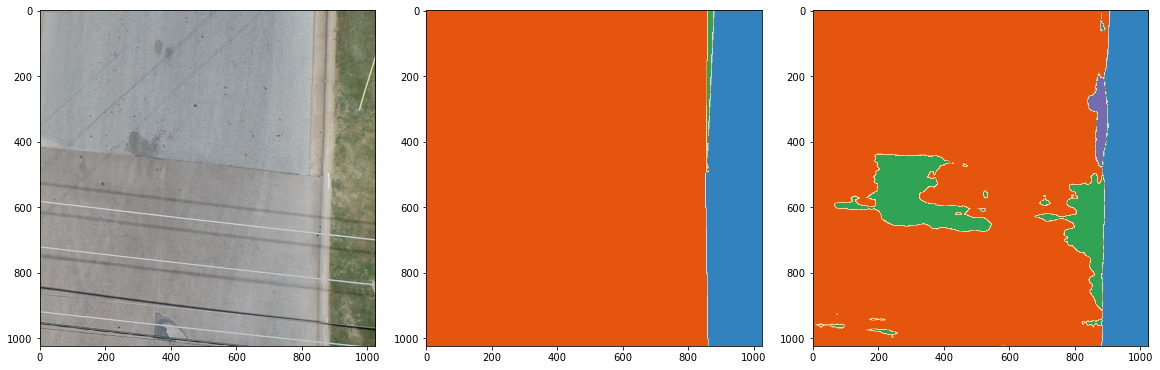

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
vmin = 0
vmax = 5
cmap = 'tab20c'
axs[0].imshow(img)
axs[1].imshow(mask_orig,cmap=cmap,vmin=vmin, vmax=vmax)
axs[2].imshow(pred_map, cmap=cmap,vmin=vmin, vmax=vmax)

# Ignore following section